In [1]:
import logging

In [2]:
class IgnorePLFilter(logging.Filter):
    def filter(self, record):
        keywords = ['available:', 'CUDA', 'LOCAL_RANK:']
        return not any(keyword in record.getMessage() for keyword in keywords)
    
logging.getLogger('pytorch_lightning.utilities.rank_zero').addFilter(IgnorePLFilter())
logging.getLogger('pytorch_lightning.accelerators.cuda').addFilter(IgnorePLFilter())

In [3]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [4]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [5]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape
from sklearn.preprocessing import MaxAbsScaler
from darts.dataprocessing.transformers import Scaler

In [7]:
import optuna

In [8]:
optuna_storage_path = "optuna_journal_storage.log"
lock_obj = optuna.storages.journal.JournalFileOpenLock(optuna_storage_path)
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(optuna_storage_path, lock_obj=lock_obj)
)

In [9]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [10]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [11]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series, observation_end='2025-04-30').rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [12]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [13]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [14]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [15]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [16]:
[print(f"{idx} {series.title} {len(data_ts[idx])}") for idx, series in enumerate(fred_series_metadata)]
print(f"{len(data_ts) - 1} UK_Daily_Policy_Data {len(data_ts[5])}")

0 Job Postings on Indeed in the United Kingdom 1916
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom 783
2 Residential Property Prices for United Kingdom 227
3 Gross Domestic Product for United Kingdom 280
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom 842
5 UK_Daily_Policy_Data 8886


In [17]:
series_names = ["Job_Postings", "Interest_Rates", "Residential_Property_Prices", "GDP", "CPI", "Economic_Uncertainty"]

In [18]:
series_chosen = 0
series = data_ts[series_chosen]
series_name = series_names[series_chosen]

In [19]:
splitting = 0.9
visualizing = 0.8

In [20]:
train, test = series.split_before(splitting)
train, val = train.split_before(splitting)

In [21]:
scaler = MaxAbsScaler()
transformer = Scaler(scaler)

In [22]:
train = transformer.fit_transform(train)
val = transformer.transform(val)
test = transformer.transform(test)

In [23]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [24]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [25]:
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [26]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [27]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    n_epochs=100, 
    random_state=0, 
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000239E2278B80>, <__main__.LossRecorder object at 0x00000239E22789D0>]})

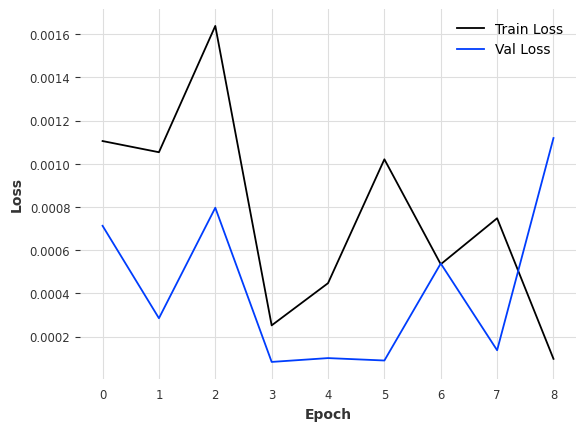

In [28]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
len(val)

174

In [30]:
val_preds = transformer.inverse_transform(nbeats_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

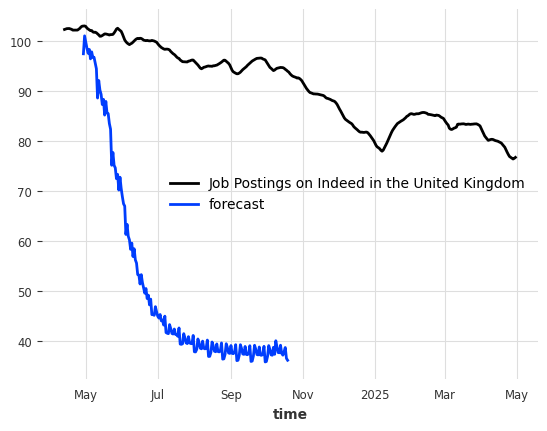

In [31]:
series.drop_before(visualizing).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [32]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.00001,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [33]:
from darts.models import RNNModel, BlockRNNModel

In [34]:
len(val)

174

In [35]:
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=3,
    dropout=0,
    batch_size=64,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-4},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=int(len(val)/2),
    input_chunk_length=int(len(val)/4),
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [36]:
lstm_model.fit(train, val_series=val, verbose=True)


  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.6 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\avey\miniforge3\envs\astp\lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (23) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.0001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000239FC470C10>, <__main__.LossRecorder object at 0x00000239FC470EE0>]})

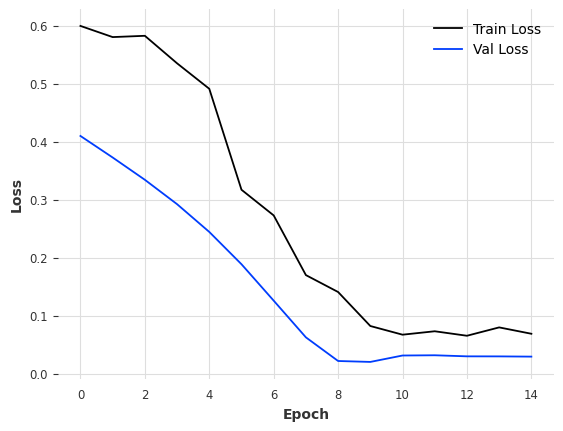

In [37]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=3, dropout=0, training_length=87, batch_size=64, n_epochs=100, optimizer_kwargs={'lr': 0.0001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=43, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x00000239F3439E40>, <__main__.LossRecorder object at 0x00000239F343A110>]})

In [39]:
val_preds = transformer.inverse_transform(lstm_model.predict(len(val)))

Predicting: |                                                                                    | 0/? [00:00<…

In [40]:
lstm_model.first_prediction_index

0

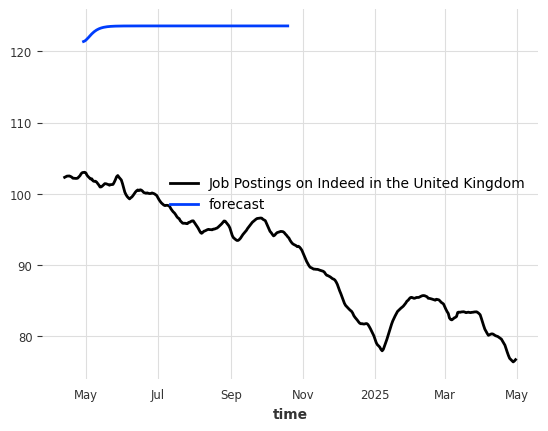

In [41]:
series.drop_before(visualizing).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [50]:
def backtest_models(series: TimeSeries, models: list, horizons: list=[1, 3, 7], points_to_test: int=100, verbose=True):
    backtest_results = dict()
    for horizon in sorted(horizons):
        print(f"Backtesting {horizon} {series.freq} horizon")
        backtests = []
        for model in models:
            print(f"Backtesting {model.model_name}")
            backtest = model.historical_forecasts(
                transformer.transform(series),
                start=len(series) - points_to_test,
                forecast_horizon=horizon,
                retrain=False,
                verbose=verbose,
            )
            backtest = transformer.inverse_transform(backtest)
            backtests.append(backtest)
        backtest_results[horizon] = {str(model.model_name): (backtests[i], mape(series, backtests[i])) for i, model in enumerate(models)}
    return backtest_results

In [51]:
def plot_backtest_results(series: TimeSeries, backtest_results: dict, points_to_test: int=100):
    for horizon, model in backtest_results.items():
        series.drop_before(len(series) - 2*points_to_test).plot(label='data')
        for model_name, (backtest, mape) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, MAPE={mape:.2f}%')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [47]:
models = [nbeats_model, lstm_model]

In [52]:
results = backtest_models(series, models=models)

Backtesting 1 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 3 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting 7 <Day> horizon
Backtesting NBEATS


Predicting: |                                                                                    | 0/? [00:00<…

Backtesting LSTM


Predicting: |                                                                                    | 0/? [00:00<…

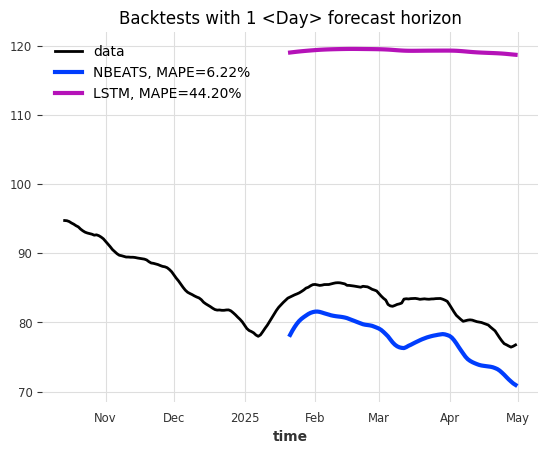

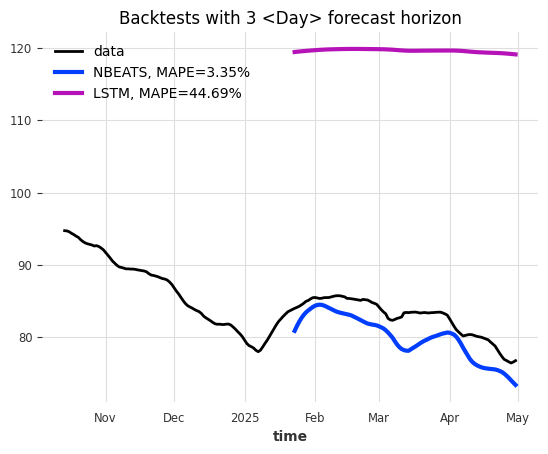

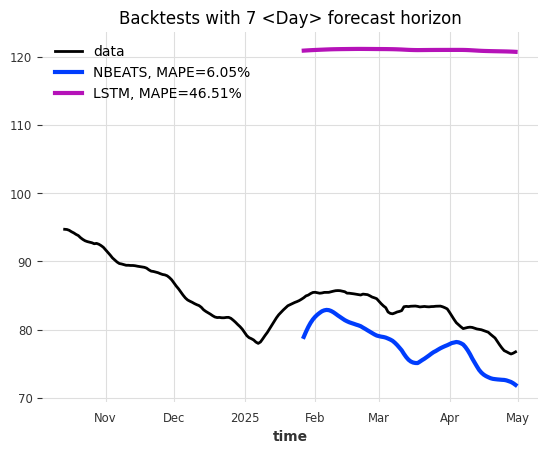

In [53]:
plot_backtest_results(series, results)

In [54]:
import optuna

In [55]:
def train_RNN(params):
    early_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
    pl_trainer_kwargs={"callbacks": [early_stopper]}
    
    model = RNNModel(
        **params,
        n_epochs=100,
        model_name=params["model"],
        log_tensorboard=True,
        random_state=7,
        training_length=int(len(val)/2),
        force_reset=True,
        save_checkpoints=True,
        pl_trainer_kwargs=pl_trainer_kwargs,
    )
    model.fit(train, val_series=val, verbose=False)
    model.load_from_checkpoint(params["model"], best=True)
    return model

In [ ]:
def optimize_RNN(trial: optuna.Trial):
    params = {
        "model": trial.suggest_categorical("model", ["RNN", "GRU", "LSTM"]),
        "hidden_dim": trial.suggest_int("hidden_dim", 2, 50),
        "n_rnn_layers": trial.suggest_int("n_rnn_layers", 1, 5),
        "dropout": trial.suggest_float("dropout", 0, 0.3),
        "batch_size": trial.suggest_int("batch_size/16", 1, 5) * 16,  # will be multiplied by 16
        "input_chunk_length": trial.suggest_int("input_chunk_length", 1, int(len(val)/4)),
        "optimizer_kwargs": {
            "lr": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
        }
    }
    if params["n_rnn_layers"] == 1:
        params["dropout"] = 0
        
    trial.set_user_attr("model_params", params)
    
    model = train_RNN(params)
    backtests = backtest_models(series[val.time_index], models=[model], horizons=[1, 2, 3, 5, 7])
    results = [model_dict[params["model"]][1]/(horizon**0.5) for horizon, model_dict in backtests.items()]
    
    return sum(results) / len(results)

In [ ]:
# Create optuna study with defined function and storage
study = optuna.create_study(
    direction="minimize",
    storage=storage,
    study_name=f"{series_name}_avg_RNNfamily_study",
    load_if_exists=True
)

In [ ]:
# Optimize for n_trials, using one thread, timeout of 5 min
study.optimize(optimize_RNN, n_trials=100, n_jobs=1, timeout=3600)

In [ ]:
study.best_trial

In [ ]:
best_model = train_RNN(study.best_trial.user_attrs["model_params"])

In [ ]:
results = backtest_models(series[test.time_index], models=[best_model], horizons=[1, 2, 3, 5, 7, 15, 30], points_to_test=75)

In [ ]:
plot_backtest_results(series[test.time_index], results, points_to_test=75)